In [1]:
import sys
import os
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize
from scipy.sparse import random
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
import scipy.stats as stats
import seaborn

# NOTE: I am ignoring the max iteration warnings for nmf
import warnings
warnings.filterwarnings("ignore")

cwd = os.getcwd()
#par = os.path.join(cwd, os.pardir)
par = os.path.dirname(cwd)
sys.path.append(par)

import sparse_nmf
import diffusion_nmf
import importlib
importlib.reload(sparse_nmf)
importlib.reload(diffusion_nmf)
from sparse_nmf import SparseNMF
from diffusion_nmf import DiffusionNMF

### Making Synthetic Data for testing

In [2]:
def gen_data():
    # generates testing data and saves it so I can test in matlab as well
    test_h = random(4,52, density = 0.07).A
    H = pd.DataFrame(test_h)

    x = np.linspace(1,10,300)
    y1 = stats.norm.pdf(x, 5) * 20
    y2 = []
    y3 = []
    y4 = []
    for i in x:
        y2.append((i - 5)**2)
        y3.append(2 * i)
        y4.append((i - 5)**3/10 + 10)
    y4 = np.array(y4)

    W = pd.DataFrame(np.array([y1, y2, y3, y4]).T)

    return W,H

In [3]:
W,H = gen_data()
X = np.dot(W,H)

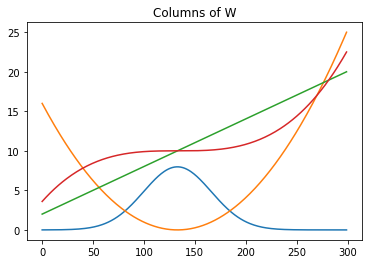

In [4]:
for col in W:
    plt.plot(W.loc[:,col])
    plt.title("Columns of W")

Text(0.5, 1.0, 'Sparse H')

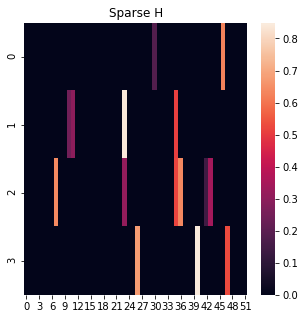

In [5]:
plt.figure(figsize = (5,5))
seaborn.heatmap(H, square = False, cbar = True)
plt.title("Sparse H")

In [6]:
# sparseness of H
h_sparse = 0
for row in H.index:
    rh = np.array(H.loc[row,:])
    sp = math.sqrt(len(rh)) - (sum(np.abs(rh))/ math.sqrt(sum(rh ** 2)))
    sp /= (math.sqrt(len(rh)) - 1)
    h_sparse += sp
    
h_sparse /= len(H.index)
print(h_sparse)
    

0.8795535854462593


In [7]:
# sparseness of W
w_sparse = 0
for col in W.columns:
    cw = np.array(W.loc[:,col])
    sp = math.sqrt(len(cw)) - (sum(np.abs(cw))/ math.sqrt(sum(cw ** 2)))
    sp /= (math.sqrt(len(cw)) - 1)
    w_sparse += sp
    
w_sparse /= len(W.columns)
print(w_sparse)

0.21078519104020454


### Comparing SparseNMF with Sklearn NMF

In [8]:
def plotter(data, out_W,out_H, K_in = None, title = " "):
    # plot columns of W
    fix, ax = plt.subplots(1, 2, figsize = (10,5))
    for col in spW:
        ax[0].plot(out_W.loc[:,col])
        ax[1].plot(W.loc[:,col])

    ax[0].set_title("W output for " + str(title))
    ax[1].set_title("Original columns of W")
    
    # plot heatmap of H
    fig, ax = plt.subplots(1, 2, figsize = (10,5))
    seaborn.heatmap(out_H, square = False, cbar = True, ax = ax[0])
    ax[0].set_title("H output for " + str(title))
    seaborn.heatmap(H, square = False, cbar = True, ax = ax[1])
    ax[1].set_title("Original H")
    
    plt.show()
    
    if K_in is None:
        print(title + "error on W:", np.linalg.norm(W - out_W))
        print(title + "error on H:", np.linalg.norm(H - out_H))
        print(title + "error on X:", np.linalg.norm(data - np.dot(out_W, out_H)))
    else:
        print(title + "error on W:", np.linalg.norm(W - out_W))
        print(title + "error on H:", np.linalg.norm(H - out_H))
        print(title + "error on D:", np.linalg.norm(data - np.dot(out_W, np.dot(out_H,K_in))))
    print()

In [9]:
model = SparseNMF(X, 4, iterations = 500, sH = h_sparse)    
model.solver()
spW = pd.DataFrame(model.W)
spH = pd.DataFrame(model.H)

#### Sparse NMF

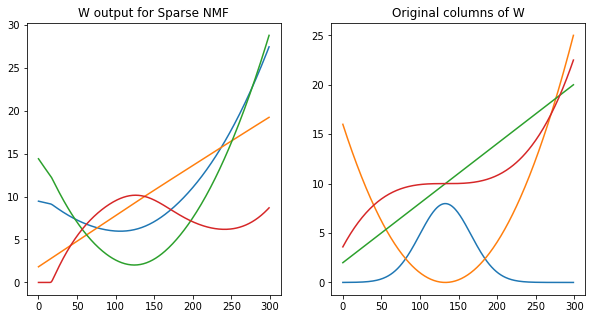

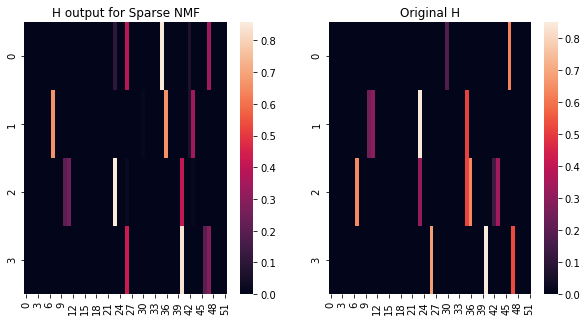

Sparse NMFerror on W: 281.1637111446361
Sparse NMFerror on H: 2.342941598312894
Sparse NMFerror on X: 32.39257000375034



In [10]:
plotter(X, spW, spH, title = "Sparse NMF")

#### Sklearn

In [11]:
model2 = NMF(n_components = 4, init = 'random', random_state = 35, max_iter = 500)
sciW = pd.DataFrame(model2.fit_transform(X))
sciH = pd.DataFrame(model2.components_)

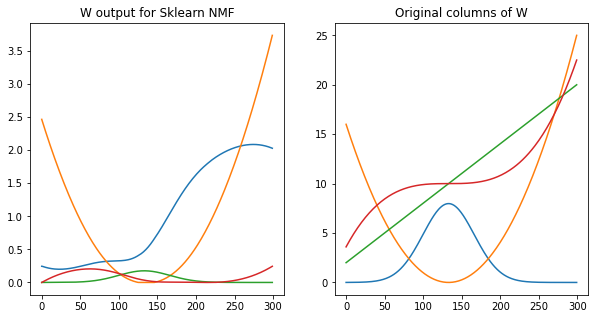

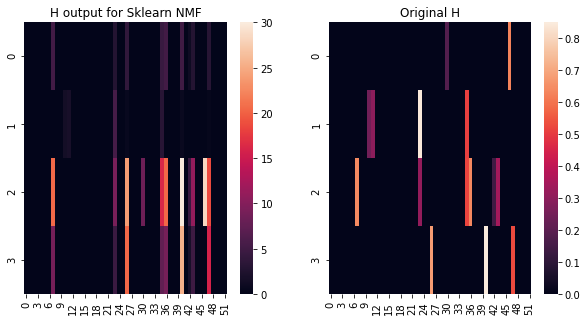

Sklearn NMFerror on W: 328.7840204064135
Sklearn NMFerror on H: 75.03290097010097
Sklearn NMFerror on X: 0.4173871759233462



In [12]:
plotter(X, sciW, sciH, title = "Sklearn NMF")

# Diffusion NMF

### Random Laplacian

In [13]:
# Making a synthetic laplacian and corresponding diffusion kernel:
def make_lapl(zero_prob, ones_prob):
    locs = X.shape[1]
    lapl = np.zeros((locs,locs))
    
    for i in range(lapl.shape[0]):
        for j in range(lapl.shape[1]):
            if i == j:
                break
            else:
                lapl[i,j] = -1 * np.random.choice([0,1], p = [zero_prob, ones_prob])
                lapl[j,i] = lapl[i,j]
    
    for i in range(lapl.shape[0]):
        lapl[i,i] = abs(lapl[i].sum())
        
    return lapl

In [14]:
I = np.identity(X.shape[1])

### Analyzing condition number of K

In [15]:
betav = 3
probs = np.flip(np.linspace(0,1,20))
connections = []
cond = []
for prob in probs:
    lapp = make_lapl(prob, 1 - prob)
    
    connections.append(np.trace(lapp))
    
    Kt = np.linalg.inv(I + betav * lapp)
    cond.append(np.linalg.cond(Kt))

Text(0, 0.5, 'Condition number')

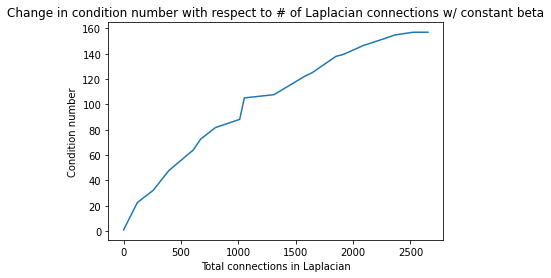

In [16]:
plt.plot(connections, cond)
plt.title("Change in condition number with respect to # of Laplacian connections w/ constant beta")
plt.xlabel("Total connections in Laplacian")
plt.ylabel("Condition number")

In [17]:
lapx = make_lapl(0.7, 0.3)
betas = np.linspace(1,30,30)
cond = []
for b in range(30):
    Kx = np.linalg.inv(I + b * lapx)
    cond.append(np.linalg.cond(Kx))

Text(0, 0.5, 'Condition number')

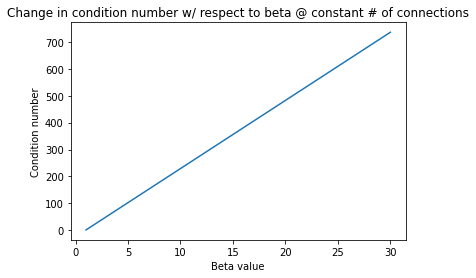

In [18]:
plt.plot(betas, cond)
plt.title("Change in condition number w/ respect to beta @ constant # of connections")
plt.xlabel("Beta value")
plt.ylabel("Condition number")

In [19]:
def diffn_plot(w, h, lap, beta_vals, sparseness = None, iters = 1000, proj = False, lstsq = False):
    # plot the diffusion NMF results over a range of beta values
    # parameters include original w and h, the laplacian, desired level of sparseness, total iterations for NMf
    # and options for a projection version of the algorithm and an alternating least squares version
    
    for beta in beta_vals:
            Kinv = I + beta * lap
            K = np.linalg.inv(Kinv)
                
            D = np.dot(w, np.dot(h, K))
            print("K Condition Number : " + str(np.linalg.cond(K)))

            differ = DiffusionNMF(D, K, ncomponents = 4, sparseV = sparseness, sparseX = None, iterations = iters, tol = 1e-20, proj = proj)
            if lstsq == False:
                differ.solver()
            else:
                differ.least_square_solver(1,1)
                
            diffX = pd.DataFrame(differ.X)
            diffV = pd.DataFrame(differ.V)

            plotter(D, diffX, diffV, K_in = K, title = "Diffusion NMF @ beta = " + str(beta))

In [20]:
L = make_lapl(0.7, 0.3)

In [21]:
# total number of edges
np.trace(L)

866.0

K Condition Number : 27.605473655318217


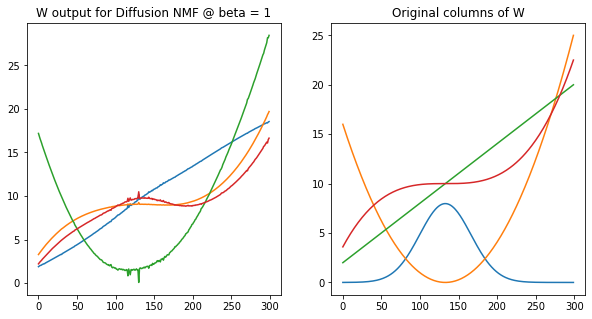

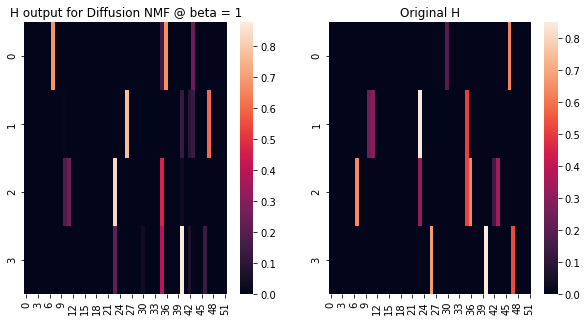

Diffusion NMF @ beta = 1error on W: 239.49004197635188
Diffusion NMF @ beta = 1error on H: 2.4157679007773245
Diffusion NMF @ beta = 1error on D: 2.279500775496466

K Condition Number : 80.8164209659548


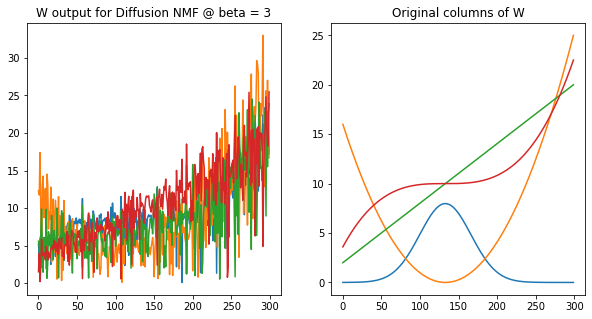

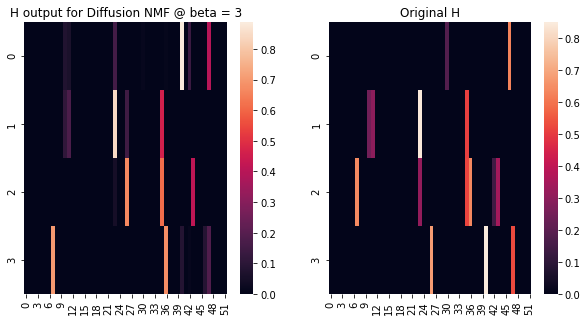

Diffusion NMF @ beta = 3error on W: 206.9454302218483
Diffusion NMF @ beta = 3error on H: 2.22886324905324
Diffusion NMF @ beta = 3error on D: 1.9911585802267762

K Condition Number : 267.0547365531822


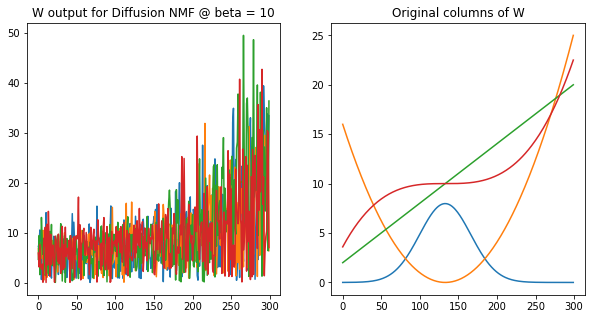

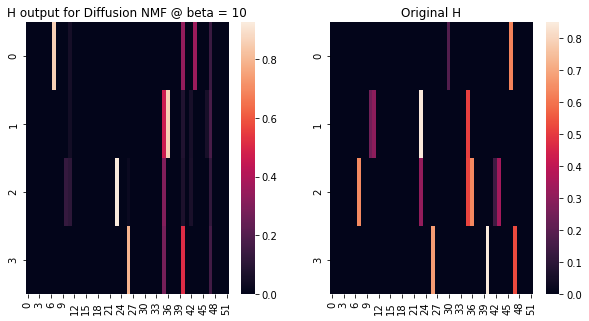

Diffusion NMF @ beta = 10error on W: 275.5067221286851
Diffusion NMF @ beta = 10error on H: 2.190727224833986
Diffusion NMF @ beta = 10error on D: 1.0989378894794342



In [22]:
diffn_plot(W,H,L, [1,3,10], sparseness = h_sparse)

### State adjacency Laplacian

In [23]:
state_L = pd.read_csv(os.path.join(par, "collected_data/state_laplacian.csv"), index_col = 0).to_numpy()

In [24]:
np.trace(state_L)

218

K Condition Number : 10.95709432694549


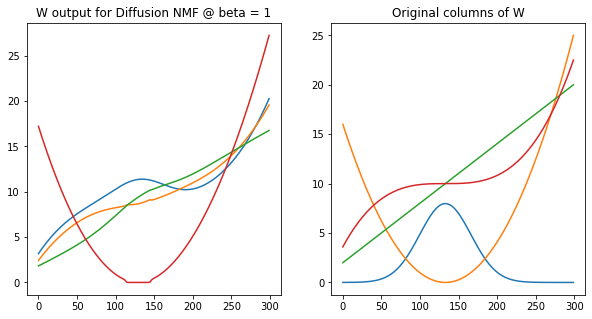

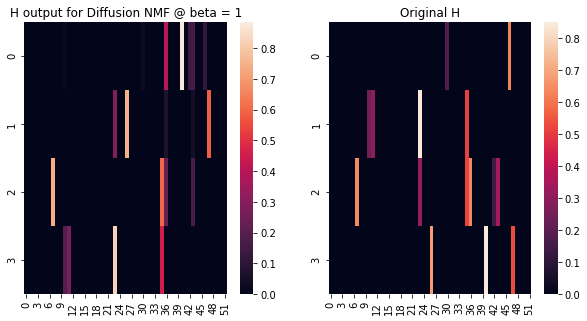

Diffusion NMF @ beta = 1error on W: 231.53272829244455
Diffusion NMF @ beta = 1error on H: 2.3834909604634893
Diffusion NMF @ beta = 1error on D: 13.733895640248946

K Condition Number : 30.871282980836465


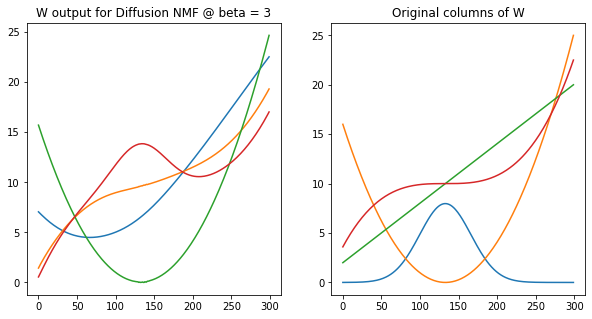

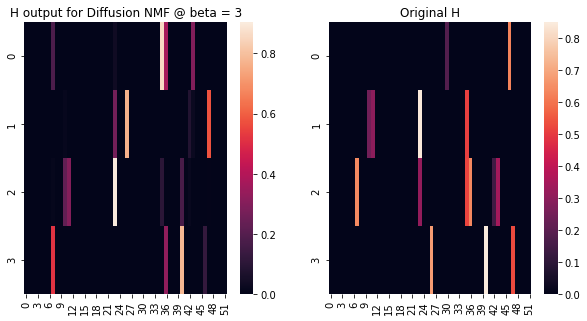

Diffusion NMF @ beta = 3error on W: 262.4666776670286
Diffusion NMF @ beta = 3error on H: 2.4194374833604515
Diffusion NMF @ beta = 3error on D: 6.645667846756715

K Condition Number : 100.57094326945528


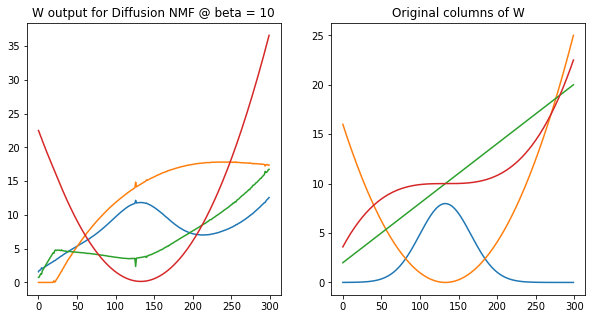

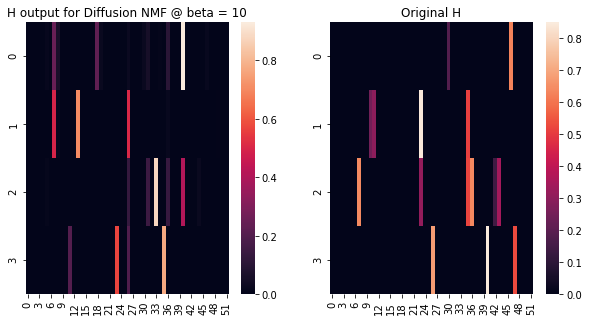

Diffusion NMF @ beta = 10error on W: 268.82690575701605
Diffusion NMF @ beta = 10error on H: 2.8034074086419154
Diffusion NMF @ beta = 10error on D: 7.174477947267838



In [25]:
diffn_plot(W,H,state_L, [1,3,10], sparseness = h_sparse)

### Modified Multiplicative update

K Condition Number : 10.95709432694549


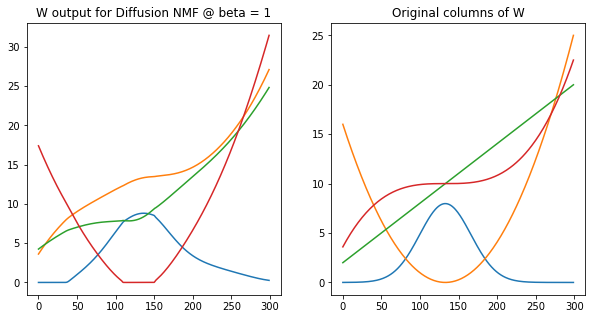

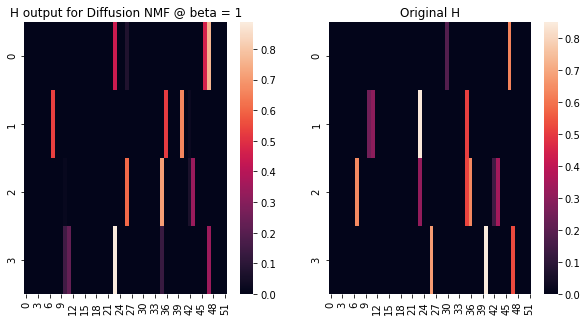

Diffusion NMF @ beta = 1error on W: 202.0406913795054
Diffusion NMF @ beta = 1error on H: 2.526649252219051
Diffusion NMF @ beta = 1error on D: 14.053518507374676

K Condition Number : 30.871282980836465


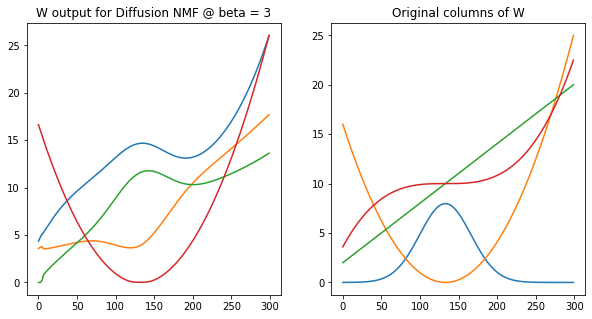

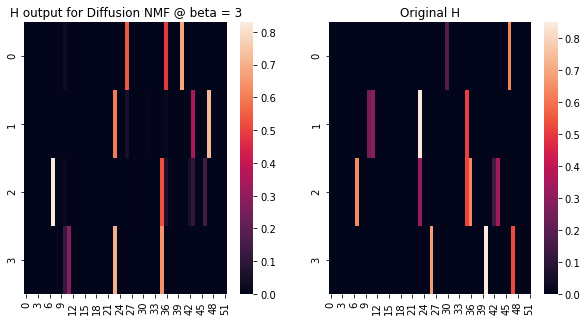

Diffusion NMF @ beta = 3error on W: 267.680864801116
Diffusion NMF @ beta = 3error on H: 2.3557247434549895
Diffusion NMF @ beta = 3error on D: 7.9799592277095766

K Condition Number : 70.69966028861833


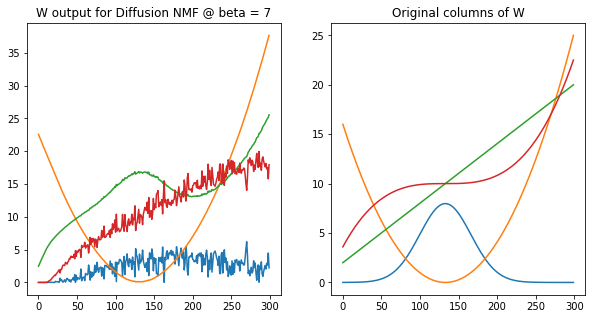

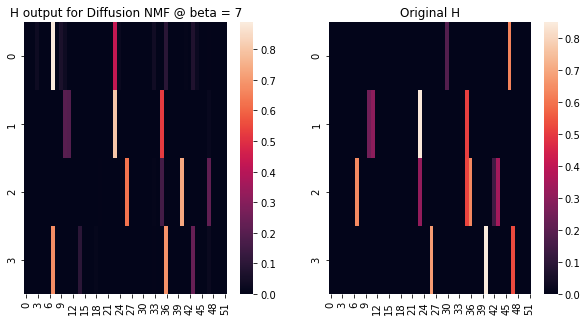

Diffusion NMF @ beta = 7error on W: 134.2766379401155
Diffusion NMF @ beta = 7error on H: 2.4573333136944306
Diffusion NMF @ beta = 7error on D: 6.578814930734527

K Condition Number : 100.57094326945528


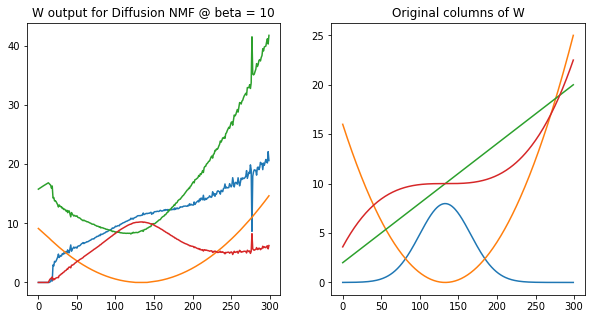

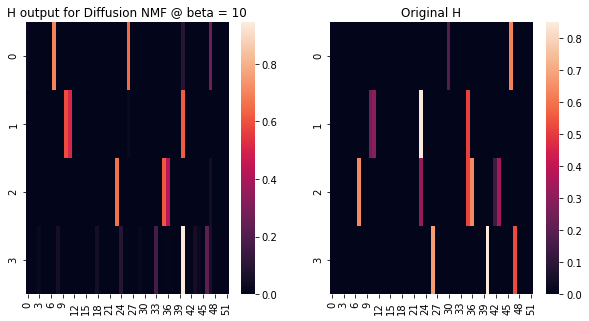

Diffusion NMF @ beta = 10error on W: 270.8989780263666
Diffusion NMF @ beta = 10error on H: 2.1126381419868343
Diffusion NMF @ beta = 10error on D: 3.762873838905494



In [26]:
# do the derived multiplicative updates but project after each V update
diffn_plot(W,H,state_L, [1,3,7,10], sparseness = h_sparse, proj = True)

### Two phase algorithm

In [27]:
def two_phase(x, v, lap, beta_vals, sparseness, iters = 500):
    for beta in beta_vals:
            Kinv = I + beta * lap
            K = np.linalg.inv(Kinv)
                
            D = np.dot(x, np.dot(v, K))
            print("K Condition Number : " + str(np.linalg.cond(K)))

            diff1 = DiffusionNMF(D, K, ncomponents = 4, sparseV = None, sparseX = None, iterations = iters, tol = 1e-20)
            diff1.solver()

            diff2 = DiffusionNMF(D,K, ncomponents = 4, sparseV = h_sparse, sparseX = None, iterations = iters, tol = 1e-20, x_init = diff1.X, v_init = diff1.V)
            diff2.solver()
            
            diffX = pd.DataFrame(diff2.X)
            diffV = pd.DataFrame(diff2.V)

            plotter(D, diffX, diffV, K_in = K, title = "two phase Diffusion NMF @ beta = " + str(beta))

K Condition Number : 10.95709432694549


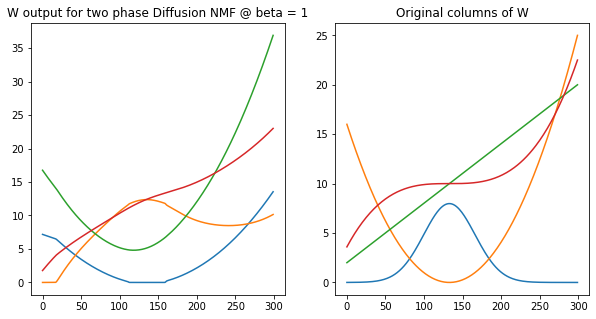

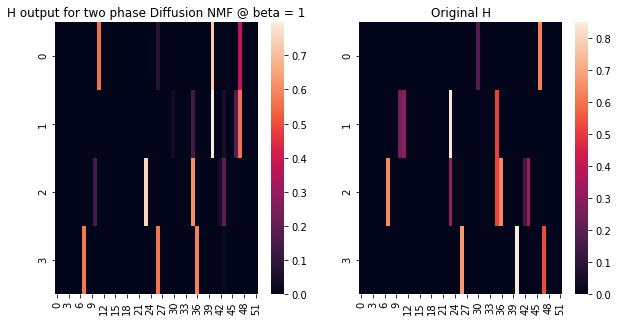

two phase Diffusion NMF @ beta = 1error on W: 223.6256996512988
two phase Diffusion NMF @ beta = 1error on H: 2.484047339906293
two phase Diffusion NMF @ beta = 1error on D: 13.675203694211898

K Condition Number : 30.871282980836465


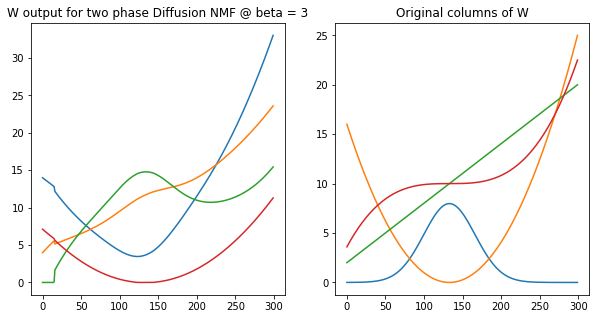

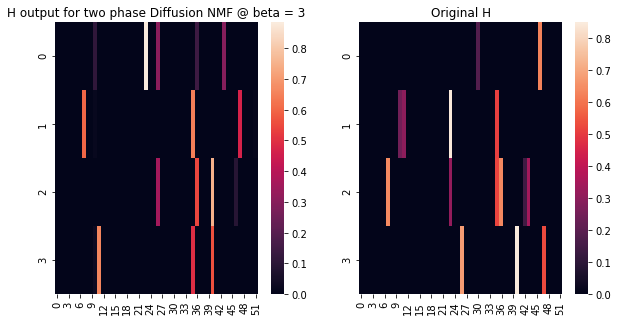

two phase Diffusion NMF @ beta = 3error on W: 321.552549769034
two phase Diffusion NMF @ beta = 3error on H: 2.4530264313715002
two phase Diffusion NMF @ beta = 3error on D: 7.9407135457684195

K Condition Number : 70.69966028861833


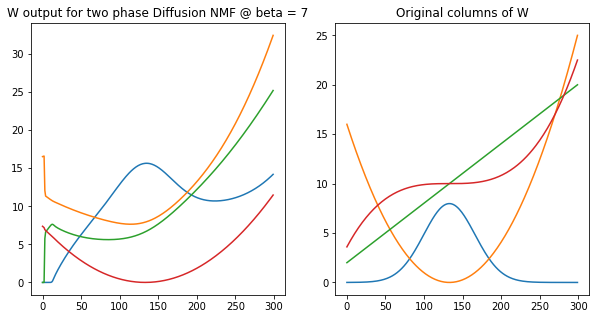

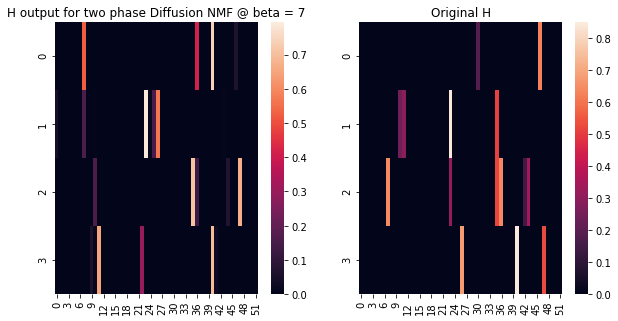

two phase Diffusion NMF @ beta = 7error on W: 250.62171117663303
two phase Diffusion NMF @ beta = 7error on H: 2.1993596687364034
two phase Diffusion NMF @ beta = 7error on D: 5.218244329587809

K Condition Number : 100.57094326945528


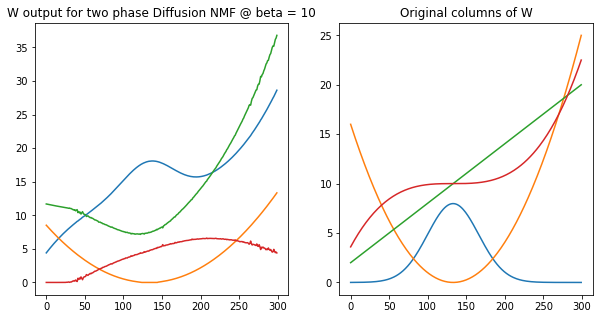

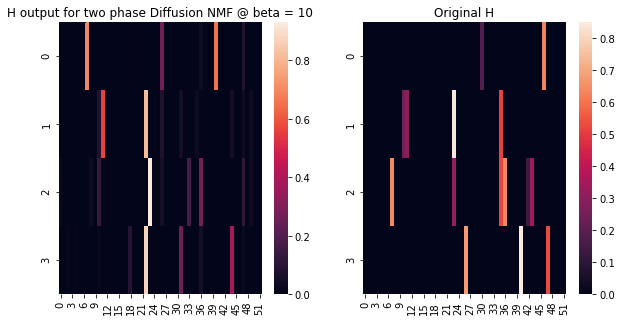

two phase Diffusion NMF @ beta = 10error on W: 313.6621680165319
two phase Diffusion NMF @ beta = 10error on H: 2.640462377670411
two phase Diffusion NMF @ beta = 10error on D: 7.621613039699944



In [28]:
two_phase(W,H,state_L, [1,3,7,10], sparseness = h_sparse, iters = 1000)

### Least squares algorithm

K Condition Number : 10.95709432694549


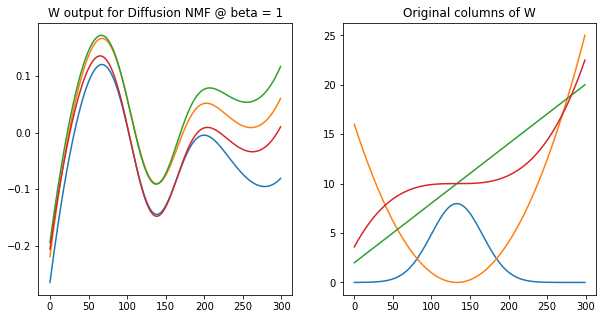

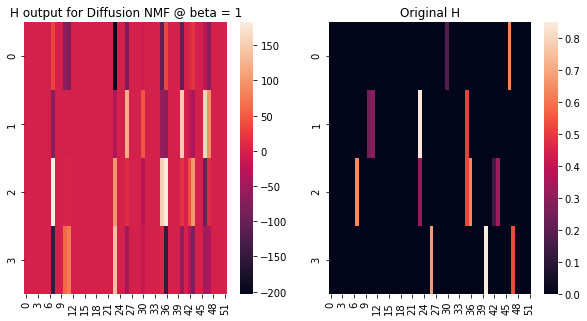

Diffusion NMF @ beta = 1error on W: 341.75603969691383
Diffusion NMF @ beta = 1error on H: 624.7048159500835
Diffusion NMF @ beta = 1error on D: 2.0000137031089693

K Condition Number : 30.871282980836465


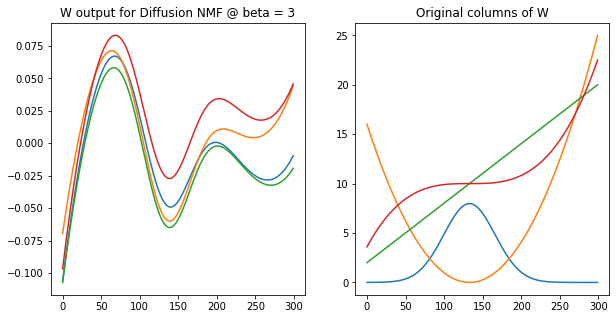

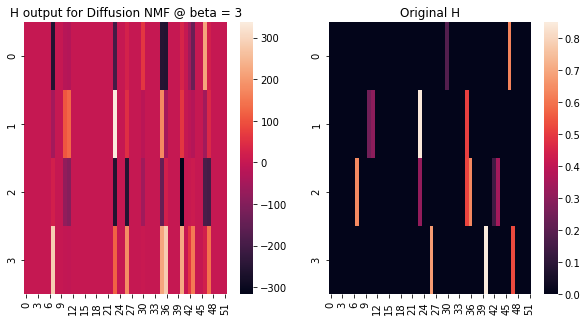

Diffusion NMF @ beta = 3error on W: 341.9272767071716
Diffusion NMF @ beta = 3error on H: 1098.2484503466676
Diffusion NMF @ beta = 3error on D: 2.0000010957303487

K Condition Number : 70.69966028861833


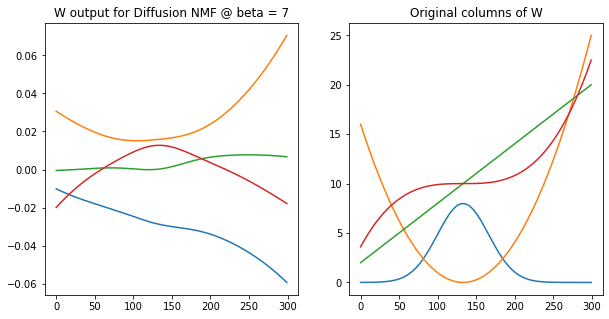

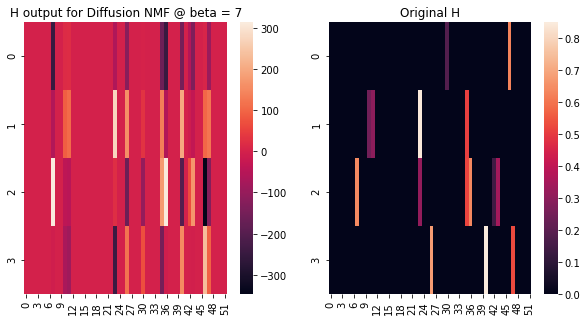

Diffusion NMF @ beta = 7error on W: 341.8079456663001
Diffusion NMF @ beta = 7error on H: 1051.4977938706872
Diffusion NMF @ beta = 7error on D: 1.3957960711157298

K Condition Number : 100.57094326945528


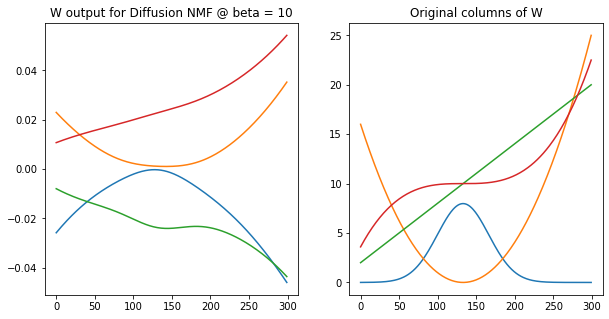

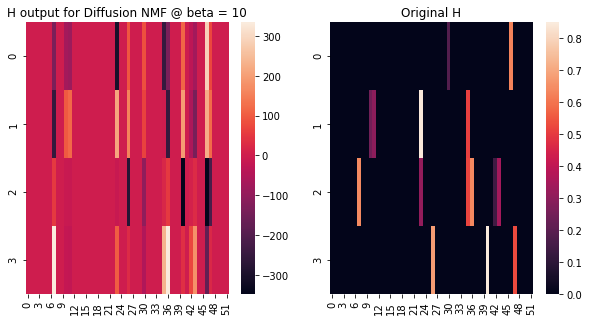

Diffusion NMF @ beta = 10error on W: 341.8883648873788
Diffusion NMF @ beta = 10error on H: 1189.9665620724124
Diffusion NMF @ beta = 10error on D: 1.0253840458807455



In [29]:
diffn_plot(W,H,state_L, [1,3,7,10], sparseness = None, iters = 10000, lstsq = True)